In [237]:
import numpy as np
from numpy.linalg import inv
from numpy import matmul as mul
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags as sdiags
from IPython import display

# Crank Nicolson Scheme

$\partial_{\tau} \psi = \frac{\hbar}{2}\Delta^{2} \psi$
$$\frac{v_{m}^{n+1} - v_{m}^{n}}{\Delta \tau} = 
\frac{\nu}{2}\left[\frac{v_{m+1}^{n+1} - 2v_{m}^{n+1} + v_{m-1}^{n+1}}{\left(\Delta x\right)^{2}}
+ \frac{v_{m+1}^{n} - 2v_{m}^{n} + v_{m-1}^{n}}{\left({\Delta x}\right)^{2}}\right]$$
where $\nu$ is $\frac{\hbar}{2m}$

$\sigma = \frac{\nu \Delta t}{2 \Delta x^{2}}$

In [238]:
t0 = 0
tf = 10
L = 10
x0 = -0.5 * L
xf = 0.5 * L

In [388]:
def initial_cond(x):
    init = (np.random.rand(x.size) -0.5)* 150
    init = -1 * x*x
    init -= init[0]
    nn = np.linalg.norm(init)
    nn = 1.0 / nn
    init *= nn
    return init


In [389]:
def potential(x):
    # return 0.5 * x * x
    return np.zeros_like(x)

In [401]:
def mesh(t, *xs):
    '''
    Parameters
    mu : dt/dx^2
    h = dx
    x0, xf, t0, tf
    '''
    # Unpack
    dt = t[0]
    t0 = t[1]
    tf = t[2]

    ti = np.arange(t0, tf, dt)
    xi = [np.arange(x[1], x[2]+x[0], x[0]) for x in xs[0]]
    dx = [x[0] for x in xs[0]]
    # print(ti.shape)
    
    Xs = np.meshgrid(ti, *xi)
    u = np.zeros_like(Xs)


    # x = np.linspace(x0, xf, int((xf-x0)/h) + 1)
    # t = np.linspace(t0, tf, int((tf-t0)/k) + 1)
    # # print(x.size)
    # xx, _ = np.meshgrid(x, t)
    # u = np.zeros_like(xx)
    # # print(u.shape)
    # u[0, :] = initial_cond(x, L)
    return Xs, dx

In [402]:
t = (0.1, 0, 10)
x = (0.1, -1, 1), (0.1, -2, 2), (0.1, -3, 3)
Xs, dx = mesh(t, x)

In [403]:
dx

[0.1, 0.1, 0.1]

In [411]:
Xs[0].shape

(21, 100, 41, 61)

In [ ]:
def ftcs(grid, )

In [242]:
def matrix(mu, u, pot=None):
    ll = u
    maindiag = np.zeros(ll)
    maindiag[:] = 2*(1+mu)
    subdiag = np.zeros(ll-1)
    subdiag[:] = mu
    A = sdiags([maindiag, subdiag, subdiag], [0,1,-1]).toarray()

    maindiag2 = np.zeros_like(maindiag)
    maindiag2[:] = 2*(1-mu)

    if pot is not None:
        maindiag2 += pot

    B = sdiags([maindiag2, subdiag, subdiag], [0,1,-1]).toarray()
    return inv(A), B

    

In [243]:
def solver(u, mu, A, B, DL, DR):
    sol = mul(A, B)
    bj = np.zeros_like(u)
    bj[0] = mu*DL ; bj[-1] = mu*DR
    # bj1[0] = mu*DL ; bj[-1] = mu*DR

    v = mul(sol, u) + bj
    return v

In [254]:
def cn(mesh, mu, DL, DR, h, func_pot=None):
    pot = None
    if func_pot is not None:
        pot = func_pot(mesh[0, :])

    def energy(psi, h, pot=None):
        if pot is None:
            pot = np.zeros_like(psi)
        psi_sqr = psi * psi
        # nn = 1 / np.sum(psi_sqr[1:-1])

        # Potential
        pot_ener = pot[1:-1] * psi_sqr[1:-1]
        # Kinetic
        lap_psi = psi[:-2] + psi[2:] - 2 * psi[1:-1]
        diff = 1 / (2 * h*h)
        lap_psi *= diff
        kin_ener = psi[1:-1] * lap_psi

        ener = np.sum(pot_ener - kin_ener)
        return ener

    arr_ener = np.zeros(mesh.shape[0])
    arr_ener[0] = energy(mesh[0, :], h, pot)

    mat1, mat2 = matrix(mu, mesh.shape[1], pot=pot)
    for i in range(1, mesh.shape[0]):
        mesh[i, :] = solver(mesh[i-1, :], mu, mat1, mat2, DL, DR)
        mesh[i, :] = mesh[i, :]/np.sqrt(((mesh[i, :]**2)*h).sum())
        arr_ener[i] = energy(mesh[i, :], h, pot)
    return mesh, arr_ener


In [ ]:
def ftcs

In [255]:
mu = 0.01
h = 0.1

In [256]:
grid, x = mesh(mu, h, x0, xf, t0, tf)

In [257]:
u, ene = cn(grid, mu, 0, 0, h, func_pot=potential)

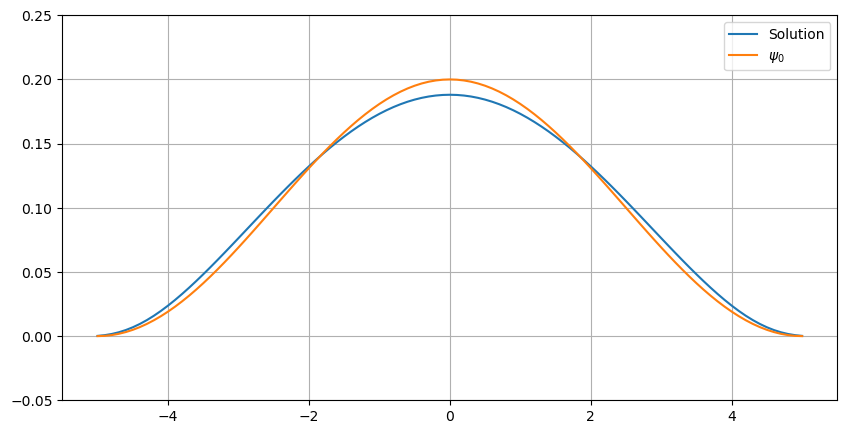

In [258]:
plt.figure(figsize=(10,5))
plt.ylim(-0.05, 2.5/L)
# for i in range(1, u.shape[0]//2, 30):
#     plt.plot(x, u[i, :], label=f"{i}")
x_c = x[0, :]
psi = u[-1, :]
plt.plot(x_c, psi**2, label='Solution')
# plt.plot(x_c, np.pi ** -0.25 * np.exp(-0.5 * x_c**2), label='$\psi_0$')
plt.plot(x_c, 2/L * np.cos(np.pi * x_c / L)**2, label='$\psi_0$')

plt.grid(True)
plt.legend()
plt.show()

In [259]:
from itertools import cycle

In [260]:
def plotting_anim(x, ux, title='', skip_rate=1, labels=None, fmts=None, **kwargs):
    """
    x --> mesh --> (N_steps, N_space)
    ux --> [ux_1, ux_2, ..., exact] --> (N_sols, N_steps, N_space)
    """
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$u(t, x)$')
    ax.grid(True)
    ax.set_title(title)
    
    ux = np.asarray(ux)
    print(ux.shape)
    ux = ux[:, ::skip_rate ,:]

    # The number of solutions.
    n_sols = ux.shape[0]

    if labels is None:
        labels = ['NSol_' + str(i) for i in range(1, n_sols)]
        labels.append('Exact')

    if fmts is None:
        fmts = [c for _, c in zip(range(n_sols), cycle('bgrcmyk'))]
        fmts[0] += '-'

    lines = []
    for _, fmt, l in zip(reversed(ux), reversed(fmts), reversed(labels)):
        line, = ax.plot([], [], fmt, label=l, alpha=0.9, lw=5)
        lines.append(line)
        ax.set_xlim(-5, 5)
        ax.set_ylim(-2, 2)
    fig.legend()

    def animate(frame_num):
        ax.set_title(f'{title} FRAME={frame_num * skip_rate:04d}')
        for line, u, x_coord in zip(lines, ux, x):
            y = u[frame_num, :]
            line.set_data((x_coord, y))
        return lines

    anim = FuncAnimation(fig, animate, frames=ux[0].shape[0], interval=100)
    video = anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()

In [261]:
plotting_anim(x, [u], title='Problem $(b)$', skip_rate=5000, fmts=('c.', 'r-'))

(1, 100000, 101)


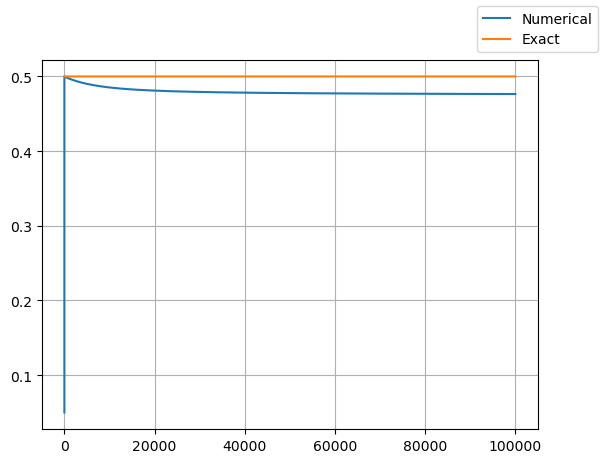

In [262]:
fig, ax = plt.subplots()
ax.plot(ene, label='Numerical')

# e0 = 0.5 * np.pi**2 / L**2
e0 = 0.5
ax.plot(e0 * np.ones_like(ene), label='Exact')

# ax.set_ylim(0.0, 0.1)
fig.legend()

ax.grid()
plt.show(fig)

In [263]:
ene[-1] - e0, h

(-0.02351920753516945, 0.1)